# Полезные практики, неочевидные моменты

## Неоднозная грамматика

Есть примитивная рекурсивная грамматика:
```
A -> a | a a
B -> A B | A
```

Есть строка "a a a". Парсер может разобрать её 3 способами:
```
(a) (a) (a)
(a) (a a)
(a a) (a)
```

Yargy парсер перебирает все варианты разбора. Используем непубличный метод `extract`, посмотрим все варианты:

R0 -> R1 R0 | R1
R1 -> 'a' | 'a' 'a'


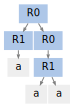

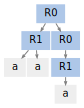

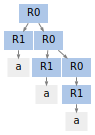

In [1]:
from yargy.parser import prepare_trees
from yargy import Parser, or_, rule

A = or_(
    rule('a'),
    rule('a', 'a')    
)
B = A.repeatable()
display(B.normalized.as_bnf)

parser = Parser(B)
matches = parser.extract('a a a')
for match in matches:
    # кроме 3-х полных разборов, парсёр найдёт ещё 7 частичных: (a) _ _, (a a) _, (a) (a) _, ...
    # не будем их показывать
    if len(match.tokens) == 3:
        display(match.tree.as_dot)

Число вариантов быстро растёт. Для строки "a x 10", парсер переберёт 89 разборов. Для "a x 20" — 979 и потратит заметное количество времени.

При работе с естественным русским языком, мы построянно сталкиваемся с неоднозначными грамматиками. Например, список из трёх взысканий по арбиражному делу: "5 тыс. р. штраф пени 3 тыс. р. необоснованного обогащения". Эскиз грамматики:
```
MONEY -> INT тыс. р.
TYPE -> штраф | пени | необоснованное обогащение

# 1. "5 тыс. р. штраф"
# 2. "штраф 5 тыс. р."
# 3. "3 тыс. р." — только сумма
# 4. "пени" — только тип
PENALTY -> MONEY TYPE | TYPE MONEY | MONEY | TYPE

PENALTIES -> PENALTY+
```

Получаем много вариантов разбора:
```
(5 тыс. р. штраф) (пени) (3 тыс. р. необоснованного обогащения)
(5 тыс. р. штраф) (пени) (3 тыс. р.) (необоснованного обогащения)
(5 тыс. р.) (штраф) (пени) (3 тыс. р.) (необоснованного обогащения)
(5 тыс. р. штраф) (пени 3 тыс. р.) (необоснованного обогащения)
...
```

Самый просто способ избежать комбинаторного взрыва числа разборов — ограничить `repeatable`. Вместо `PENALTIES = PENALTY.repeatable()`, напишем `PENALTIES = PENALTY.repeatable(max=5)`. Такое правило отбросить 6-е и последующие взыскания, но завершится в ограниченное время.

## CappedParser

Есть ещё один способ избежать комбинаторного взрыва числа разборов: выключать парсер, когда число состояний превысило порог. `CappedParser` наследует `Parser`, оборачивает внутренние методы `chart`, `predict`, `scan`, `complete` — шаги алгоритма Earley-парсера:

In [2]:
class TooManyStates(Exception): pass


def capped(method):
    def wrap(self, column, *args):
        before = len(column.states)
        method(self, column, *args)
        after = len(column.states)

        self.states += (after - before)
        if self.cap and self.states > self.cap:
            raise TooManyStates

    return wrap


class CappedParser(Parser):
    def reset(self):
        self.states = 0

    def __init__(self, *args, cap=None, **kwargs):
        self.cap = cap
        self.reset()
        Parser.__init__(self, *args, **kwargs)

    def chart(self, *args, **kwargs):
        self.reset()
        return Parser.chart(self, *args, **kwargs)

    predict = capped(Parser.predict)
    scan = capped(Parser.scan)
    complete = capped(Parser.complete)
    

parser = CappedParser(B, cap=100)
for size in range(3, 10):
    text = 'a ' * size
    print(text)
    try:
        parser.match(text)
    except TooManyStates:
        print('TooManyStates')
    else:
        print('OK')


a a a 
OK
a a a a 
OK
a a a a a 
OK
a a a a a a 
TooManyStates
a a a a a a a 
TooManyStates
a a a a a a a a 
TooManyStates
a a a a a a a a a 
TooManyStates


## Порядок аргументов в `or_` имеет значение

Когда разборов больше одного, парсер возвращает самый левый вариант:

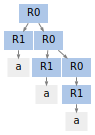

In [3]:
A = or_(
    rule('a'),
    rule('a', 'a')    
)
B = A.repeatable()

parser = Parser(B)
match = parser.match('a a a')
match.tree.as_dot

Переставим местами `a a` и `a`, результат поменяется:

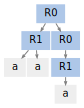

In [4]:
A = or_(
    rule('a', 'a'),
    rule('a')
)
B = A.repeatable()

parser = Parser(B)
match = parser.match('a a a')
match.tree.as_dot

На практике это важно. В примере со взыскиниями грамматика:
```
PENALTY -> MONEY TYPE | TYPE MONEY | MONEY | TYPE
```

Левый разбор, не то, что ожидалось:
```
(5 тыс. р. штраф) (пени 3 тыс. р.) (необоснованного обогащения)`
```

Переставим аргументы:
```
PENALTY -> MONEY TYPE |  TYPE | TYPE MONEY | MONEY
```

Получим:
```
(5 тыс. р. штраф) (пени) (3 тыс. р. необоснованного обогащения)`
```


## IdTokenizer

`Parser` принимает на вход текст. Первым делом парсер разделяет текст на токены. Токенизатор передаётся необязательным аргументом `tokenizer`: `Parser(RULE, tokenizer=Tokenizer())`. Токенизатор по-умолчанию — `yargy.tokenizer.MorphTokenizer`.

Бывает нужно обработать уже токенизированный текст. Например, есть два парсера, нужно обоими обработать один текст. Хотим сэкономить время, не токенизировать текст дважды. Заведём парсер-обёртку, он ничего не делает, принимает и возращает токены:

In [5]:
from yargy.tokenizer import (
    Tokenizer,
    MorphTokenizer,
    EOL
)


# Стандартный токенизатор. Удаляем правило для переводом строк.
# Обычно токены с '\n' только мешаются.
TOKENIZER = MorphTokenizer().remove_types(EOL)


class IdTokenizer(Tokenizer):
    def __init__(self, tokenizer):
        self.tokenizer = tokenizer

    # Используется при инициализации morph_pipeline, caseless_pipeline.
    # Строки-аргументы pipeline нужно разделить на слова. Как разделить,
    # например, "кейс| |dvd-диска" или "кейс| |dvd|-|диска"? Используем стандартный токенизатор.
    def split(self, text):
        return self.tokenizer.split(text)

    # Используется при инициализации предикатов. Например, есть предикат type('INT').
    # Поддерживает ли токенизатор тип INT?
    def check_type(self, type):
        return self.tokenizer.check_type(type)

    @property
    def morph(self):
        return self.tokenizer.morph

    def __call__(self, tokens):
        return tokens


ID_TOKENIZER = IdTokenizer(TOKENIZER)

tokens = TOKENIZER('a a a a')
parser = Parser(B, tokenizer=ID_TOKENIZER)
parser.match(tokens);

## `ValueError: no .interpretation(...) for root rule`

Есть два правила, хотим найти факты, где сработало одно из них:

In [6]:
from yargy.interpretation import fact


F = fact('F', ['a'])
G = fact('G', ['b'])


A = rule('a').interpretation(F.a).interpretation(F)
B = rule('b').interpretation(G.b).interpretation(G)
C = or_(A, B)
parser = Parser(C)

match = parser.match('a')
# match.fact ValueError

Ожидаем `F(a='a')`, получаем `ValueError: no .interpretation(...) for root rule`. На вершине-корне нет пометки контруктора факта:

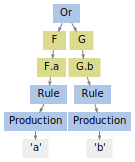

In [7]:
C.as_dot

Создадим прокси-факт:

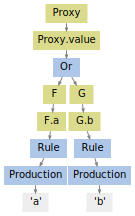

F(
    a='a'
)

In [8]:
Proxy = fact('Proxy', ['value'])

C = or_(A, B).interpretation(Proxy.value).interpretation(Proxy)
display(C.as_dot)

parser = Parser(C)
match = parser.match('a')
match.fact.value


## `TypeError: mixed types`

Набор аргументов `or_` бывает двух видов:
1. Все предикаты, тогда результат — предикат
2. Все `rule`, тогда результат — `rule`

Иногда правило состоит из одного предиката, передаём его в `or_`, получаем ошибку:

In [9]:
from yargy.predicates import caseless

A = rule('a')
B = caseless('b')
# or_(A, B)  # TypeError: mixed types: [<class 'yargy.rule.constructors.Rule'>, <class 'yargy.predicates.bank.eq'>]

Явно завернём предикат в `rule`:

In [10]:
B = rule(caseless('b'))
C = or_(A, B)

## Машинное обучение и Yargy

Есть текст размеченный BIO-тегами:

In [11]:
text = '15 апреля в Симферополе Леонид Рожков ...'
tags = 'B I O B B I O'.split()

`Parser` принимает необязательный аргумент `tagger`: `Parser(RULE, tagger=Tagger)`. `Tagger` принимает и возвращает список токенов. Добавим внешнюю разметку `tags` в токены. Используем предикат `tag`, извлечём сущности:

In [12]:
from yargy.tagger import Tagger
from yargy.predicates import tag


class Tagger(Tagger):
    # Все возможные теги. Используется при инициализации предиката tag.
    # Если пользователь создаст tag('FOO'), будет ошибка
    tags = {'B', 'I', 'O'}

    def __call__(self, tokens):
        for token, tag in zip(tokens, tags):
            yield token.tagged(tag)


RULE = rule(
    tag('B'),
    tag('I').repeatable().optional()
)
parser = Parser(RULE, tagger=Tagger())

matches = parser.findall(text)
for match in matches:
    print([_.value for _ in match.tokens])

['15', 'апреля']
['Симферополе']
['Леонид', 'Рожков']


## Пропустить часть текста

Есть текст "взыскать 5 тыс. р. штрафа, а также пени и неустойку". Нужно выделить 3 взыскания "5 тыс. р. штраф", "пени", "неустойка", пропустить подстроки ", а также", "и". Запустить парсер 2 раза: сначала выделим взыскания, удалим лишние токены, запустим парсер ещё раз: 

In [13]:
from yargy.pipelines import morph_pipeline

text = 'взыскать 5 тыс. р. штрафа, а также пени и неустойку'
tokens = list(TOKENIZER(text))


PAYMENT = morph_pipeline([
    '5 тыс. р. штраф',
    'пени',
    'неустойка'
])
parser = Parser(PAYMENT, tokenizer=ID_TOKENIZER)

matches = parser.findall(tokens)
spans = [_.span for _ in matches]
print(spans)


def is_inside_span(token, span):
    token_span = token.span
    return span.start <= token_span.start and token_span.stop <= span.stop


def select_span_tokens(tokens, spans):
    for token in tokens:
        if any(is_inside_span(token, _) for _ in spans):
            yield token


tokens = list(select_span_tokens(tokens, spans))
print([_.value for _ in tokens])

PAYMENTS = PAYMENT.repeatable()
parser = Parser(PAYMENTS, tokenizer=ID_TOKENIZER)
match = parser.match(tokens)

[[9, 25), [35, 39), [42, 51)]
['5', 'тыс', '.', 'р', '.', 'штрафа', 'пени', 'неустойку']


## Генерация правил

В Yargy все правила описываются на языке Python. Создадим функцию, которая генерирует правило. Например, правило для текста в скобочка и кавычках:

In [14]:
from yargy import not_
from yargy.predicates import eq


def bounded(start, stop):
    return rule(
        eq(start),
        not_(eq(stop)).repeatable(),
        eq(stop)
    )


BOUNDED = or_(
    bounded('[', ']'),
    bounded('«', '»')
)
parser = Parser(BOUNDED)
matches = parser.findall('[a b] {c d} «e f»')
for match in matches:
    print([_.value for _ in match.tokens])

['[', 'a', 'b', ']']
['«', 'e', 'f', '»']


Правило — аналог `join` в Python:

In [15]:
from yargy.predicates import in_


def joined(ITEM, SEP):
    return rule(
        ITEM,
        rule(
            SEP,
            ITEM
        ).repeatable().optional()
    )


SEP = in_(',;')
JOINED = joined(BOUNDED, SEP)
parser = Parser(JOINED)
match = parser.match('[a b], [c d], [e f g]')

Правило для BIO-разметки:

In [16]:
def bio(type):
    return rule(
        tag('B-%s' % type),
        tag('I-%s' % type).repeatable().optional()
    )


PER = bio('PER')
LOC = bio('LOC')


text = '15 апреля в Симферополе Леонид Рожков ...'
tags = 'B-DATE I-DATE O B-LOC B-PER I-PER O'.split()


class Tagger(Tagger):
    tags = {'B-PER', 'I-PER', 'B-LOC', 'I-LOC', 'O'}

    def __call__(self, tokens):
        for token, tag in zip(tokens, tags):
            yield token.tagged(tag)


RULE = or_(PER, LOC)
parser = Parser(RULE, tagger=Tagger())
matches = parser.findall(text)
for match in matches:
    print([_.value for _ in match.tokens])

['Симферополе']
['Леонид', 'Рожков']


## Генерация `pipeline`

Создадим `pipeline` из словаря пар "полное название", "сокращение":

In [17]:
from yargy.pipelines import (
    morph_pipeline,
    pipeline
)
from yargy import interpretation as interp


TYPES = [
    ('Общество с ограниченной ответственностью', 'ООО'),
    ('Акционерное общество', 'АО'),
    ('Страховая компания', 'СК'),
    ('Строительная компания', 'СК')
]

TYPE = or_(
    morph_pipeline([
        name for name, abbr in TYPES
    ]),
    pipeline([
        abbr for name, abbr in TYPES
    ])
)

RULE = TYPE.repeatable()
parser = Parser(RULE)
matches = parser.findall('Акционерное общество, в Акционерном обществе; АО, СК')
for match in matches:
    print([_.value for _ in match.tokens])

['Акционерное', 'общество']
['Акционерном', 'обществе']
['АО']
['СК']


## Наследование `fact`

`fact` создаёт Python-класс, отнаследуемся, добавим методы и атрибуты. Например, есть ссылка на статьи "ст. 15-17 п.1", результат список объектов `Ref(art=15, punkt=1), Ref(art=16, punkt=1), ...`:

In [18]:
from collections import namedtuple

from yargy.predicates import type


Ref_ = namedtuple(
    'Ref',
    ['art', 'punkt']
)


Art = fact(
    'Art',
    ['start', 'stop']
)
class Art(Art):
    def range(self):
        if self.stop:
            return range(self.start, self.stop + 1)
        else:
            return [self.start]


Punkt = fact(
    'Punkt',
    ['number']
)


Ref = fact(
    'Ref',
    ['art', 'punkt']
)
class Ref(Ref):
    def range(self):
        for art in self.art.range():
            punkt = (
                self.punkt.number
                if self.punkt
                else None
            )
            yield Ref_(art, punkt)
            
            
INT = type('INT')

ART = rule(
    'ст', '.',
    INT.interpretation(Art.start.custom(int)),
    rule(
        '-',
        INT.interpretation(Art.stop.custom(int))
    ).optional()
).interpretation(Art)

PUNKT = rule(
    'п', '.',
    INT.interpretation(Punkt.number.custom(int))
).interpretation(Punkt)

REF = rule(
    ART.interpretation(Ref.art),
    PUNKT.optional().interpretation(Ref.punkt)
).interpretation(Ref)

parser = Parser(REF)
lines = [
    'ст. 15-17 п.1',
    'ст. 15 п.2',
    'ст. 16'
]
for line in lines:
    print(line)
    match = parser.match(line)
    print(list(match.fact.range()))

ст. 15-17 п.1
[Ref(art=15, punkt=1), Ref(art=16, punkt=1), Ref(art=17, punkt=1)]
ст. 15 п.2
[Ref(art=15, punkt=2)]
ст. 16
[Ref(art=16, punkt=None)]


Есть периоды "1917-1918г.", "21 век", приведём их к единому формату: `Period(1917, 1919)`, `Period(2000, 2100)`.

In [19]:
Period_ = namedtuple('Period', ['start', 'stop'])


Year = fact(
    'Year',
    ['value']
)
class Year(Year):
    @property
    def normalized(self):
        return Period_(self.value, self.value + 1)


YearRange = fact(
    'YearRange',
    ['start', 'stop']
)
class YearRange(YearRange):
    @property
    def normalized(self):
        return Period_(self.start, self.stop + 1)
    
    
Century = fact(
    'Century',
    ['value']
)
class Century(Century):
    @property
    def normalized(self):
        start = (self.value - 1) * 100
        return Period_(start, start + 100)


Period = fact(
    'Period',
    ['value']
)
class Period(Period):
    @property
    def normalized(self):
        return self.value.normalized


YEAR = rule(
    INT.interpretation(Year.value.custom(int)),
    'г', '.'
).interpretation(Year)

YEAR_RANGE = rule(
    INT.interpretation(YearRange.start.custom(int)),
    '-',
    INT.interpretation(YearRange.stop.custom(int)),
    'г', '.'
).interpretation(YearRange)

CENTURY = rule(
    INT.interpretation(Century.value.custom(int)),
    'век'
).interpretation(Century)

PERIOD = or_(
    YEAR,
    YEAR_RANGE,
    CENTURY
).interpretation(Period.value).interpretation(Period)

parser = Parser(PERIOD)
lines = [
    '1917-1918г.',
    '21 век',
    '1990г.'
]
for line in lines:
    match = parser.match(line)
    print(line)
    print(match.fact.normalized)

1917-1918г.
Period(start=1917, stop=1919)
21 век
Period(start=2000, stop=2100)
1990г.
Period(start=1990, stop=1991)
